In [1]:
import time

import cv2
import matplotlib.pyplot as plt

In [21]:
!ffmpeg -f avfoundation -list_devices true -i ""

ffmpeg version 7.1.1 Copyright (c) 2000-2025 the FFmpeg developers
  built with Apple clang version 16.0.0 (clang-1600.0.26.6)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.1.1_1 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex

Configuration

In [17]:
camera_index = 1

Attempt to grab the camera

In [18]:
cap = cv2.VideoCapture(camera_index)

if not cap.isOpened():
    print(f'Error: Could not open camera at index {camera_index}.')
else:
    print(f'Camera at index {camera_index} opened successfully.')
    backend_name = cap.getBackendName()
    print(f'Backend name: {backend_name}')

    width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
    height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
    print(f'Default Resolution: {int(width)}x{int(height)}')

Camera at index 1 opened successfully.
Backend name: AVFOUNDATION
Default Resolution: 1280x960


In [13]:
if cap.isOpened():
    # --- Properties to Check ---
    # Note: Not all cameras support all properties!
    # Values might be 0 or -1 if unsupported or in auto mode.
    # Some properties might have different ranges (e.g., 0-255, 0.0-1.0)

    props_to_check = {
        'BRIGHTNESS': cv2.CAP_PROP_BRIGHTNESS,
        'CONTRAST': cv2.CAP_PROP_CONTRAST,
        'SATURATION': cv2.CAP_PROP_SATURATION,  # Often related
        'HUE': cv2.CAP_PROP_HUE,
        'GAIN': cv2.CAP_PROP_GAIN,
        'EXPOSURE': cv2.CAP_PROP_EXPOSURE,  # Manual exposure time
        'AUTO_EXPOSURE': cv2.CAP_PROP_AUTO_EXPOSURE,  # 0 or 1 usually
        'AUTOFOCUS': cv2.CAP_PROP_AUTOFOCUS,  # 0=off, 1=on
        # "SETTINGS": cv2.CAP_PROP_SETTINGS # Sometimes opens a driver dialog, not useful here
    }

    print('\n--- Initial Camera Properties ---')
    initial_settings = {}
    for name, prop_id in props_to_check.items():
        value = cap.get(prop_id)
        initial_settings[name] = value
        print(f'{name}: {value}')
    print('------------------------------\n')

else:
    print('Camera not open. Run the previous cell successfully first.')



--- Initial Camera Properties ---
BRIGHTNESS: 0.0
CONTRAST: 0.0
SATURATION: 0.0
HUE: 0.0
GAIN: 0.0
EXPOSURE: 0.0
AUTO_EXPOSURE: 0.0
AUTOFOCUS: 0.0
------------------------------



In [14]:
if cap.isOpened():
    print('\n--- Attempting to Set Manual Controls ---')

    # 1. Try to disable Auto Exposure
    # Common values: 0 or 1 might disable it. Sometimes 0.25 means manual. Needs experimentation.
    print('Attempting to disable AUTO_EXPOSURE...')
    # Let's try setting it to 1 (often means 'manual' for APIs like V4L2,
    # less common for AVFoundation)
    # Or try 0. Let's start with 1, then maybe try 0 if it fails.
    # Experiment: Try setting AUTO_EXPOSURE to 0 or 1 here
    desired_auto_exposure_mode = 0  # Try 0 first for disabling auto mode
    ret_ae = cap.set(cv2.CAP_PROP_AUTO_EXPOSURE, desired_auto_exposure_mode)
    time.sleep(0.5)  # Give camera time to potentially adjust
    current_ae = cap.get(cv2.CAP_PROP_AUTO_EXPOSURE)
    print(
        f'Set AUTO_EXPOSURE to {desired_auto_exposure_mode}? Success: {ret_ae}. Current value: {current_ae}'
    )
    if current_ae != desired_auto_exposure_mode and ret_ae:
        print('WARN: Auto Exposure did not seem to stick to the desired value.')
    elif not ret_ae:
        print('WARN: Setting Auto Exposure likely not supported or failed.')

    # 2. Try to disable Autofocus (if applicable)
    # print("Attempting to disable AUTOFOCUS...")
    # cap.set(cv2.CAP_PROP_AUTOFOCUS, 0) # 0 usually means off
    # time.sleep(0.5)
    # print(f"Current AUTOFOCUS value: {cap.get(cv2.CAP_PROP_AUTOFOCUS)}")

    # 3. Try setting manual values (ONLY if auto exposure seems off)
    # ** IMPORTANT: Ranges vary wildly! Defaults are often 0-255 but can be different. **
    # ** You MUST experiment with values for *your specific camera* **
    desired_settings = {
        'BRIGHTNESS': 128,  # Example: Mid-range for 0-255
        'CONTRAST': 64,  # Example value
        'GAIN': 100,  # Example value - range can be very different!
        # "EXPOSURE": -6, # Example: Often logarithmic
    }

    print('\nAttempting to set desired manual values...')
    final_settings = {}
    for name, value in desired_settings.items():
        prop_id = props_to_check.get(name)
        if prop_id is not None:
            print(f'Setting {name} to {value}...')
            ret_set = cap.set(prop_id, float(value))  # Use float for safety
            time.sleep(0.1)  # Small delay
            current_val = cap.get(prop_id)
            final_settings[name] = current_val
            print(f'  Set Success: {ret_set}, Current {name}: {current_val}')
            if not ret_set:
                print(f'  WARN: Setting {name} likely not supported or failed.')
            # Optional: Check if value is close to what we set
            # if ret_set and not np.isclose(current_val, float(value), atol=1):
            #    print(f"  WARN: {name} value ({current_val}) differs significantly from set value ({value}).")

    print('---------------------------------------\n')

else:
    print('Camera not open.')



--- Attempting to Set Manual Controls ---
Attempting to disable AUTO_EXPOSURE...
Set AUTO_EXPOSURE to 0? Success: False. Current value: 0.0
WARN: Setting Auto Exposure likely not supported or failed.

Attempting to set desired manual values...
Setting BRIGHTNESS to 128...
  Set Success: False, Current BRIGHTNESS: 0.0
  WARN: Setting BRIGHTNESS likely not supported or failed.
Setting CONTRAST to 64...
  Set Success: False, Current CONTRAST: 0.0
  WARN: Setting CONTRAST likely not supported or failed.
Setting GAIN to 100...
  Set Success: False, Current GAIN: 0.0
  WARN: Setting GAIN likely not supported or failed.
---------------------------------------



Frame captured successfully.


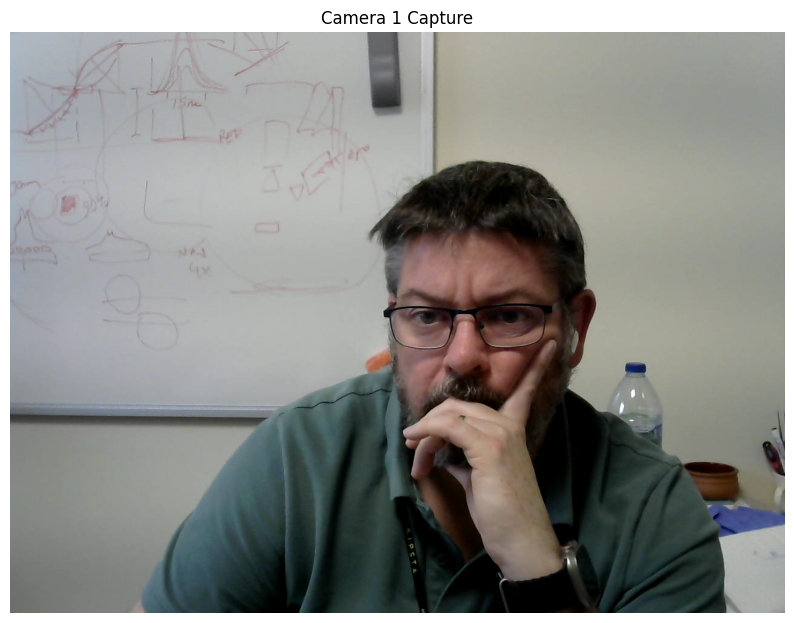

In [19]:
if cap.isOpened():
    ret, frame = cap.read()

    if not ret:
        print('Error: Failed to capture frame.')
    else:
        print('Frame captured successfully.')
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(10, 8))
        plt.imshow(frame_rgb)
        plt.title(f'Camera {camera_index} Capture')
        plt.axis('off')
        plt.show()
else:
    print('Camera not open.')


In [20]:
if cap.isOpened():
    cap.release()
    print(f'Camera {camera_index} released.')
    # Optional check
    print(f"Is camera open? {cap.isOpened()}")


Camera 1 released.
Is camera open? False
